In [0]:
import tensorflow as tf
import os

In [0]:
from google.colab import drive

In [0]:
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [0]:
project_path = "/content/gdrive/My Drive/Face Recognition/"

In [0]:
from zipfile import ZipFile

with ZipFile(project_path +'Aligned Face Dataset from Pinterest.zip', 'r') as z:
  z.extractall()

In [0]:
path = "/content/PINS/"

In [0]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [0]:
dir_list

['pins_Aaron Paul',
 'pins_Alvaro Morte',
 'pins_Amanda Crew',
 'pins_Amaury Nolasco',
 'pins_Anna Gunn',
 'pins_Benedict Cumberbatch',
 'pins_Betsy Brandt',
 'pins_Brenton Thwaites',
 'pins_Brit Marling',
 'pins_Bryan Cranston',
 'pins_Caity Lotz',
 'pins_Cameron Monaghan',
 'pins_Chance Perdomo',
 'pins_Chris Evans',
 'pins_Chris Pratt',
 'pins_Cobie Smulders',
 'pins_Danielle Panabaker',
 'pins_Dave Franco',
 'pins_Dominic Purcell',
 'pins_Dwayne Johnson',
 'pins_Emilia Clarke',
 'pins_Emily Bett Rickards',
 'pins_Emma Stone',
 'pins_Gwyneth Paltrow',
 'pins_Henry Cavil',
 'pins_Jason Momoa',
 'pins_Jeremy Renner',
 'pins_Jesse Eisenberg',
 'pins_Jim Parsons',
 'pins_Jon Bernthal',
 'pins_Josh Radnor',
 'pins_Kit Harington',
 'pins_Krysten Ritter',
 'pins_Kumail Nanjiani',
 'pins_Maisie Williams',
 'pins_Mark Ruffalo',
 'pins_Martin Starr',
 'pins_Melissa benoit',
 'pins_Mike Colter',
 'pins_Morena Baccarin',
 'pins_Morgan Freeman',
 'pins_Natalie Portman ',
 'pins_Neil Patrick Harr

In [0]:
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path+directory)
    images.sort()
    images = [path+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) 
    orig_groups.append(images[30:])

In [0]:
len(orig_groups), len(forg_groups)

(100, 100)

In [0]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [0]:
print(orig_lengths)

[56, 61, 88, 83, 36, 51, 38, 100, 92, 50, 93, 82, 56, 58, 111, 100, 85, 96, 77, 94, 124, 46, 98, 91, 104, 103, 89, 63, 79, 31, 71, 75, 85, 60, 118, 88, 18, 92, 41, 102, 67, 87, 43, 97, 47, 64, 41, 45, 65, 69, 67, 90, 116, 77, 91, 70, 59, 52, 70, 50, 83, 117, 109, 135, 114, 121, 121, 112, 59, 56, 98, 89, 74, 8, 107, 75, 151, 55, 133, 128, 92, 95, 58, 137, 88, 46, 110, 38, 32, 51, 52, 90, 77, 52, 63, 20, 35, 69, 89, 79]


In [0]:
print(forg_lengths)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


In [0]:
orig_train, orig_val, orig_test = orig_groups[:120], orig_groups[120:140], orig_groups[140:]
forg_train, forg_val, forg_test = forg_groups[:120], forg_groups[120:140], forg_groups[140:]

In [0]:
del orig_groups, forg_groups

In [0]:
img_h, img_w = 155, 220  # converting all image to same size before processing

In [0]:
def visualize_sample_image():
    '''Function to randomly select an image from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = cv2.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

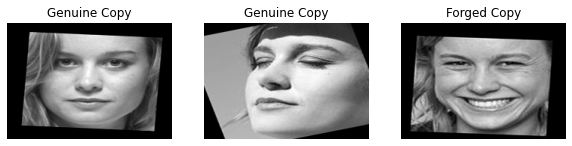

In [0]:
visualize_sample_image()

In [0]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [0]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [0]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    Source: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    
    Explanation:
    When ytrue is 1, that means the sample are duplicates of each other, 
    so the Euclidean distance (ypred) between their outputs must be minimized.
    So the loss is taken as the square of that Euclidean distance itself - K.square(y_pred).
    When ytrue is 0, i.e. the samples are not duplicates, then the Euclidean distance 
    between them must be maximized, at least to the margin. So the loss to be minimized
    is the difference of the margin and the Euclidean distance - (margin - y_pred).
    If the Euclidean distance (ypred) is already greater than the margin, 
    then nothing is to be learned, so the loss is made to be zero in 
    that case by saying K.maximum(margin - y_pred, 0).
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [0]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2)))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1'))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1'))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, activation='relu'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, activation='relu')) # softmax changed to relu
    
    return seq

In [0]:
input_shape=(img_h, img_w, 1)

In [0]:
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

In [0]:
batch_sz = 128
num_train_samples = 276*120 + 300*120
num_val_samples = num_test_samples = 276*20 + 300*20
num_train_samples, num_val_samples, num_test_samples

(69120, 11520, 11520)

In [0]:
rms = RMSprop(lr=1e-4)
model.compile(loss=contrastive_loss, optimizer=rms)

In [0]:
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/gdrive/My Drive/Face Recognition/vgg_face_weights.h5', verbose=1, save_weights_only=True)
]

In [0]:
results = model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 20,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
540/540 [==============================] - ETA: 0s - loss: 1.3939

In [0]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

In [0]:
model.load_weights('/content/gdrive/My Drive/Face Recognition/vgg_face_weights.h5')

In [0]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [0]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

In [0]:
def predict_score():
    '''Predict distance score and classify test images as genuine or false'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('genuine')
    if test_label == 1:
        ax2.set_title('genuine')
    else:
        ax2.set_title('false')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a false image")
    else:
        print("Its a genuine image")

In [0]:
predict_score()